Topic Modelling with Latent Dirichlet Allocation
==
Paper: Latent Dirichlet Allocation

Authors: David M Blei, Andrew Y Ng, Michael I Jordan 

## 1. Introduction

In natural language processing, **Latent Dirichlet Allocation (LDA)** is a widely used topic model proposed by David Blei, Andrew Ng, and Michael Jordan, capable of automatically discovering topics that documents in a corpus contain and explaining similarities between documents. LDA is a three-level hierarchical Bayesian model, and topic modeling is a classic problem in natural language processing. 

In the following report, we first describe the mechanism of Latent Dirichlet Allocation. We then use two methods to implement LDA: Variational Inference and Collapsed Gibbs Sampling.

## 2. Algorithm Description and Notations

LDA uses a generative model to explain how the observed words in the documents of a corpus are generated from latent variables. The following shows the graphical model representation of LDA:

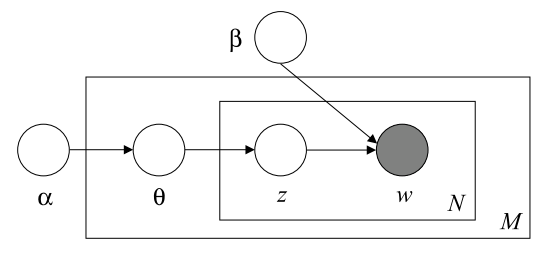

In [0]:
from IPython.display import Image
Image('LDA.png')

The boxes are "plates" representing replicates. The outer plate represents documents, while the inner plate represents the repeated choice of topics and words within a document. M denotes the number of document, N the number of words in a documents, and V indicates the size of the vocabulary of the corpus. We define the following terms:

* $\alpha$ is the parameter of the Dirichlet prior on the per-document topic distribution, 
* $\beta_i$ is the word distribution for topic k
* $\theta_m$ is the topic distribution for document m,
* $z_{mw}$ is the topic of word w in document m

LDA assumes the following generative process for each document **m** in a corpus:
1. Choose $N$ ~ Poisson($\xi$).
2. Choose $\theta$ ~ Dir($\alpha$).
3. For each of the $N$ word $w_n$:
    1. Choose a topic $z_n$ ~ Multinomial($\theta$).
    2. Choose a word $w_n$ from $p(w_n |z_n, \beta)$, a multinomial probability conditioned on the topic $z_n$.
    
Note that the length of each document $N$ does not interact with any of the other variables and is thus just assumed to be known.

### The Dirichlet Distribution

The **Dirichlet Distribution** is the multivariate generalization of the beta distribution, which means the Dirichlet distribution is a distribution over discrete probability distributions. Dirichlet distributions are oftenly used as conjugate prior distributions of the categorical distribution and multinomial distribution in Bayesian statistics. 

A *k*-dimensional Dirichlet random variable $\theta$ can take values in the (k-1)-simplex (a k-vector $\theta$ lies in the (k-1)-simplex if ${ \theta  }_{ i }\ge 0,\sum _{ i }^{ k }{ { \alpha  }_{ i } } $), and has the following probability density on the simplex:

$$p(\theta| \alpha) = \frac { \Gamma (\sum _{ i=1 }^{ k }{ { \alpha  }_{ i } } ) }{ \prod _{ i=1 }^{ k }{ \Gamma ({ \alpha  }_{ i }) }  } { { \theta  }_{ 1 } }^{ { \alpha  }_{ 1 }-1 }\cdot \cdot \cdot { { \theta  }_{ k } }^{ { \alpha  }_{ k }-1 }$$

Given the parameters $\alpha$ and $\beta$, the joint distribution of a topic mixture $\theta$, a set of $N$ topics $z$, and a set of $N$ words $w$ is given by:

$$
p(\theta, z, w|\alpha, \beta)=p(\theta|\alpha)\prod _{ n=1 }^{ N }{ p(z_n|\theta)p(w_n|z_n,\beta) } 
$$

where $p(z_n|\theta)$ is simply $\theta_i$ for the unique i such that ${ z }_{ n }^{ i }=1$. Integrating over $\theta$ and summing over z, we obtain the marginal distribution of a document:

$$
p(w|\alpha, \beta) = \int { p(\theta |\alpha )(\prod _{ n=1 }^{ N }{ \sum { p({ z }_{ n }|\theta )p({ w }_{ n }|{ z }_{ n },\beta ) }  } )d\theta  } 
$$

Finally, taking the product of the marginal probabilities of single documents, we obtain the probability of a corpus:

$$
p(D|\alpha, \beta) = \prod _{ d=1 }^{ M }{ \int { p(\theta_d |\alpha )(\prod _{ n=1 }^{ N_d }{ \sum { p({ z }_{ dn }|\theta )p({ w }_{ dn }|{ z }_{ dn },\beta ) }  } )d\theta_d  }  } 
$$

To infer the latent parameters is a problem of Bayesian inference. Next, we use Variational Inference and Gibbs Sampling to estimate latent parameters.

## 3.1 Implementation - Gibbs Sampling

In the original paper, Blei, Ng and Jordan (2002) gave a variational inference approximation of the posterior distribution, because posterior distribution is usually intractable. Since then though, Gibbs Sampling has also become a commonly used way to infer latent parameters in LDA. Here, we use Gibbs Sampling to implement LDA. Gibbs Sampling is a Markov Chain Monte Carlo method, in which the next state is reached by sequentially sampling from the full conditional distributions of all other variables and the data.

Since the Dirichlet distribution is conjugate prior of the multinomial distribution, the posteriors of $\theta_i$ and $\beta_i$ also follow the Dirichlet distribution. Their posterior means are:

$$
\theta_{i,k} = \frac { { n }_{ i }^{ k }+{ \alpha  }_{ k } }{ \sum _{ k=1 }^{ K }{ { n }_{ i }^{ k }+{ \alpha  }_{ k } }  } 
$$

$$
\beta_{k,w} = \frac { { n }_{ w }^{ k }+{ \beta  }_{ w } }{ \sum _{ w=1 }^{ W }{ { n }_{ w }^{ k }+{ \beta  }_{ w } }  } 
$$

where ${ n }_{ i }^{ k }$ is the number of words in document i that have been assigned to topic k, ${ n }_{ w }^{ k }$ is the total number words $w$ assigned to topic $k$ among all documents in the corpus.

Obviously, the inference of $\theta$ and $\beta$ only depends on assignments of each word to topics $z_i$. Therefore, we can only focus on estimation of $z_i$. We define some terms:

* $n_m$: the word count of document $m$, not including the current one 
* $n_{mz}$: the number of words from document $m$ assigned to topic $z$, not including the current one
* $n_{zw}$: the number of instances of word $w$ assigned to topic $z$, not including the current one
* $n_z$: the total number of words assigned to topic $z$, not including the current one

Then, the posterior distribution of word assignment is:

$$
p(z_i=j|z_i,w)\propto \frac { n_{zw} + \phi }{ n_z + V\phi } \cdot \frac { n_{mz} + \alpha }{ n_m + K\alpha } 
$$

And we can implement LDA by Gibbs Sampling.

### Parameters

document:    $m = 1,...,M$

topic asigned to word:       $z = 1,...,K$

word:        $w = 1,...,N_V$

vocabulary : $v = 1,...,V$

Z: topic assigned to word w

$\theta: K \times N$ 

$\beta: M \times K$ 

$Multinomial(\theta)$: distribution over words for a given topic

$Multinomial(\beta)$: distribution over topics for a given document

$n_m$, $n_{mz}$, $n_{zw}$, $n_z$: as defined above

#### Import packages and functions

In [0]:
import numpy as np
from numpy import sqrt,mean,square
from scipy.special import digamma, polygamma

### Word counting function

In [0]:
def words_count_doc(corpus):
    """
    Count the total number of words in each document in corpus.

    Parameters
    ----------
    corpus : a list-like structure, contains bag-of-words of each document

    Returns
    -------
    n_m : a np.array, shape(M)
         the total number of words in each document
    """
    n_m = []
    for i in range(len(corpus)):
        n_m.append(np.sum(corpus[i], axis = 0)[1])
    return np.array(n_m)

### Initialize empty parameters

In [0]:
def empty_parameters(corpus, K, V):
    """
    Initialize empty parameters n_mz, n_zw, n_z.

    Parameters:
    -----------
    K : int, the number of topics
    V : int, the number of vocabulary
    
    Returns:
    --------
    z_mw : the topic of word w in document m
    n_mz : the number of words from document m assigned to topic z
    n_zw : the number of words assigned topic z
    n_z : the total number of words assigned to topic z
    """
    z_mw = []
    n_mz = np.zeros((len(corpus), K))
    n_zw = np.zeros((K, V))
    n_z = np.zeros(K)
    return z_mw, n_mz, n_zw, n_z

### Initialize parameters based on words in documents

In [0]:
def initial_parameters(corpus, K, V):
    """
    Initialize parameters for the corpus 

    Parameters:
    -----------
    corpus: a list-like structure, contains bag-of-words of each document
    K : int, the number of topics
    V : int, the size of the vocabulary

    Returns:
    --------
    z_mw : the topic of word w in document m
    n_mz : the number of words from document m assigned to topic z
    n_zw : the number of words assigned topic z
    n_z : the total number of words assigned to topic z
    
    """
    z_mw, n_mz, n_zw, n_z = empty_parameters(corpus, K, V)
    z_mw = []
    for m, doc in enumerate(corpus):
        z_n = []
        for n, t in doc:
            z = np.random.randint(0, K)
            z_n.append(z)
            n_mz[m, z] += t
            n_zw[z, n] += t
            n_z[z] += t
        z_mw.append(np.array(z_n))
    return z_mw, n_mz, n_zw, n_z

## Gibbs Sampling

In [0]:
def gibbs_sampling(corpus, max_iter, K, V, n_zw, n_z, n_mz, n_m, z_mw, alpha, phi):
    beta_gibbs = []
    theta_gibbs = []
    
    np.random.seed(1337)
    for i in range(max_iter):
        if i%1000 == 0:
            print(i)
        for m, doc in enumerate(corpus):
            for n, (w, t) in enumerate(doc):
                #exclude the current word
                z = z_mw[m][n]
                n_mz[m, z] -= t
                n_m[m] -= t
                n_zw[z, w] -= t
                n_z[z] -= t
        
                new_z = sample_topic(K, n_zw, n_z, n_mz, n_m, alpha, phi, w, m)

                #include the current word
                z_mw[m][n] = new_z
                n_mz[m, new_z] += t
                n_zw[new_z, w] += t
                n_z[new_z] += t
                n_m[m] += t

        #update beta
        beta_gibbs.append(update_beta(V, n_zw, n_z, alpha))
        #update theta
        theta_gibbs.append(update_theta(K, n_mz, n_m, phi))
    return beta_gibbs, theta_gibbs

def sample_topic(K, n_zw, n_z, n_mz, n_m, alpha, phi, w, m):
    """
    Sample new topic for current word
    
    """
    p_z = np.zeros(K)
    for j in range(K):
        p_z[j] = ((n_zw[j, w] + phi)/(n_z[j] + V * phi)) * ((n_mz[m, j] + alpha)/(n_m[m] + K * alpha))
    new_z = np.random.multinomial(1, p_z/p_z.sum()).argmax()
    return new_z    

def update_beta(V, n_zw, n_z, alpha):
    """
    Update beta
    """
    beta = (n_zw + alpha)/(n_z[:,None] + V *alpha)
    return beta

def update_theta(K, n_mz, n_m, phi):
    """
    Update theta
    """
    theta = (n_mz + phi)/(n_m[:, None] + K * phi)
    return theta

## 3.2 Implementation - Variational Inference

Latent Dirichlet Allocation was also implemented using variational inference. In situations where variational inference is typically used, the posterior is typically intractable to calculate directly. In the case of LDA, the posterior $p(\theta,z,w | \alpha,\beta)$ is difficult to compute, so the distribution is instead approximated with the variational distribution:

$$q(\theta,z | \gamma,\phi) = q(\theta|\gamma) \prod_{n=1}^{N} q(z_n|\phi_n)$$

Using Jensen's inequality, it can be shown that the difference between the log likelihood of the true posterior and the variational approximation is the KL-divergence between the two. In order words:

$$ \log(p(w|\alpha,\beta) = L(\gamma,\phi;\alpha,\beta) + D(q(\theta,z|\gamma,\phi)||p(\theta,z|w,\alpha,\beta))$$

We can choose to either minimize the KL-divergence or maximize the likelihood. Here, the latter is approach is taken. Factoring the likelihood appropriately, we can write the following:

$$ L(\gamma,\phi;\alpha,\beta) = E_q[\log p(\theta|\alpha)] + E_q[\log p(z|\theta)] + E_q [\log p(w|z,\beta)] - E_q [\log q(\theta)] - E_q[\log q(z)] $$

This likelihood is maximized through Expectation-Maximization (EM). During the expectation step, the variational parameters $\phi$ and $\gamma$ are first optimized by maximizing the likelihood with respect to each individually. During the maximization step, the likelihood is then maximized with respect to model parameters $\alpha$ and $\beta$. This process is outlined below.

### Variables and Parameters

document:    $m = 1,...,M$

topic:       $z = 1,...,k$

word:        $w = 1,...,N_m$

vocabulary : $v = 1,...,V$

$\alpha: 1 \times k$ Model parameter - vector of topic distribution probabilities for each document

$\beta: k \times v$ Model parameter - matrix of word probabilities for each topic

$\phi: M \times N_m \times k$ Variational parameter - matrix of topic probabilities for each word in each document

$\gamma: M \times k$ Variational parameter - matrix of topic probabilities for each document

### Optimize variational parameters $\phi$ and $\gamma$

By taking the derivative the log likelihood with respect to $\phi$ and setting the result to zero, we find the maximal value of $\phi$:

$$ \phi_{ni} \propto \beta_{iv} \exp(\Psi(\gamma_i) - \Psi(\sum_{j=1}^k(\gamma_j)) $$

where $\beta_{iv}$ = $p(w_n^v = 1|z_n = i)$ and $\Psi$ is the digamma function (derivative of the log gamma function $\Gamma$). As $\phi$ represents the probability of each word in a document for each latent topic, these values must be normalized such that each row representing a word position within a document must sum to 1.


In a similar fashion, it can be shown that $\gamma$ is maximized at:

$$ \gamma_i = \alpha_i + \sum_{n=1}^N(\phi_{ni})$$

In [0]:
## Optimize variational parameter phi
def opt_phi(beta,gamma,words,M,N,k):
    for m in range(M):
        for n in range(N[m]):
            for i in range(k):
                phi[m][n,i] = int(np.round(beta[words[m][n],i], 0)) * int(np.round(np.exp(digamma(gamma[m,i]), 0)) - int(np.round(digamma(np.sum(gamma[m,:]))), 0))
            # Normalize across states so phi represents probability over states for each word
            phi[m][n,:] = phi[m][n,:]/np.sum(phi[m][n,:])
    return phi


## Optimize variational parameter gamma
def opt_gamma(alpha,phi,M):
    gamma = np.tile(alpha,(M,1)) + np.array(list(map(lambda x: np.sum(x,axis=0),phi)))
    return gamma

### Estimate model parameters $\alpha$ and $\beta$

By taking the derivative of the log likelihood and applying the appropriate Lagrange multipliers to ensure probabilities sum to 1, we find that $/beta$ is maximized with:

$$ \beta_{ij} \propto \sum_{m=1}^M \sum_{n=1}^{N_m} \phi_{dni}w_{mn}^j$$

where $w_{mn}^j$ = 1 if the $n^{th}$ word of document $m$ is equal to $j$, and 0 otherwise. Since the columns of \beta represent the probability of each word given the topic of that particular column, they must be normalized to sum to 1.

Taking the derivative of the log likelihood with respect to $\alpha$ yields:

$$ \frac{\partial L}{\partial\alpha_i} = M(\Psi(\sum_{j=1}^k\alpha_j)-\Psi(\alpha_i)) - \sum_{m=1}^M(\Psi(\gamma_{di})-\Psi(\sum_{j=1}^k\gamma_{dj}))$$

Because this is difficult to find the zero intercept of this derivative, $\alpha$ is instead maximized numerically with the Newton-Raphson method. The Hessian is of the form:

$$ \frac{\partial^2 L}{\partial\alpha_i\partial\alpha_j} = M(\Psi'(\sum_{j=1}^k \alpha_j) - \delta(i,j)\Psi'(\alpha_i))$$ 

Note: This is slightly different from what is stated in the paper, which has a couple errors in the reported form of the Hessian.

In [0]:
## Optimize beta
def est_beta(phi,words,k,V):
    for j in range (V):
        # Construct w_mn == j of same shape as phi
        w_mnj = [np.tile((word == j),(k,1)).T for word in words]
        beta[j,:] = np.sum(np.array(list(map(lambda x: np.sum(x,axis=0),phi*w_mnj))),axis=0)
        
    # Normalize across states so beta represents probability of each word given the state
    for i in range(k):
        beta[:,i] = beta[:,i]/sum(beta[:,i])
        
    return beta


## Optimize alpha
#  (Newton-Raphson method, for a Hessian with special structure)
def est_alpha(alpha,gamma,M,k,nr_max_iters = 1000,tol = 10**-2.0):
    for it in range(nr_max_iters):
        alpha_old = alpha
        
        #  Calculate gradient 
        g = M*(digamma(np.sum(alpha))-digamma(alpha)) + np.sum(digamma(gamma)-np.tile(digamma(np.sum(gamma,axis=1)),(k,1)).T,axis=0)
        #  Calculate Hessian diagonal component
        h = -M*polygamma(1,alpha) 
        #  Calculate Hessian constant component
        z = M*polygamma(1,np.sum(alpha))
        #  Calculate constant
        c = np.sum(g/h)/(z**(-1.0)+np.sum(h**(-1.0)))

        #  Update alpha
        alpha = alpha - (g-c)/h
        
        #  Check convergence
        if sqrt(mean(square(alpha-alpha_old)))<tol:
            break
        
    return alpha

## 4. Conclusion

We implemented in Python via Gibbs Sampling and Variational Inference. Using the Dirchlet distribution as a prior, the goal was to discover latent topics among documents in a corpus. We simulated a dataset according to the generative process in Blei et al's paper. We then used LDA to estimate the latent variables and compared them with real latent variables in the generating process. We can try to improve the performance of our Gibbs sampling method with Cython.

## References

[1] Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." the Journal of machine Learning research 3 (2003): 993-1022.

[2] Griffiths, Tom. "Gibbs sampling in the generative model of latent dirichlet allocation." (2002).